## New Review Graphs

Compute range: 1.68e+17 → 1.34e+22


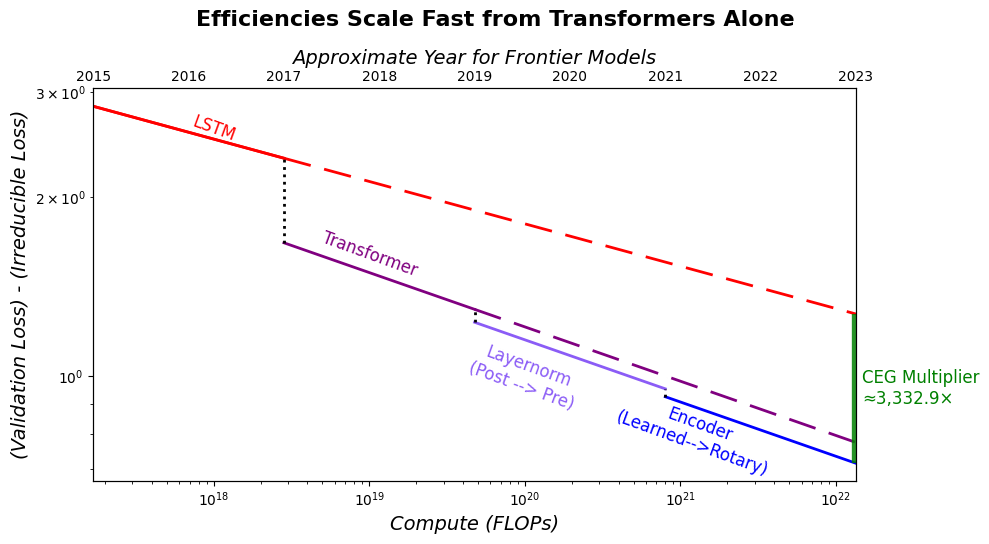

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter


A0, alpha0, E = 47.4, 0.071, 1.8
# Configuration
CONFIG = {
    'plot_years': (2015.0, 2023.0),
    'colors': {
        'baseline': 'red',
        'segments': ['red', 'purple', '#8B5CF6', 'blue'],
        'transition': 'black',
        'efficiency': 'green'
    },
    'transitions': [
        ('Transformer', 1e19, 3.4 - E),
        ('Layernorm\n(Post --> Pre)', 10**20, 1),
        ('Encoder\n(Learned-->Rotary)', 10**21.1, 0.8)
    ],
    'label_rotation': -20,
    'fontsize': 12
}



segments = [
    (-np.inf, 2017, A0, alpha0),
    (2017, 2019.0, 80, 0.091),
    (2019, 2021, 80*(1.73**-0.091), 0.091),
    (2021, np.inf, 80*((1.27*1.1*1.73)**-0.091), 0.091),
]

def year_to_compute(year, y0=2013, C0=1e16, k=np.log(4.1)/1.0):
    return C0 * np.exp(k * (year - y0))

def chinchilla_irreducible(A, alpha, C):
    return A * (C ** (-alpha))

def plot_transition(ax, segments, idx, label, label_x, label_y, label_color='black', line_color='black', rotation=20, fontsize=10):
    """Plot transition line and label between two segments."""
    _, y_trans, A1, a1 = segments[idx]
    _, _, A2, a2 = segments[idx + 1]
    
    C_trans = year_to_compute(y_trans)
    L1, L2 = chinchilla_irreducible(A1, a1, C_trans), chinchilla_irreducible(A2, a2, C_trans)
    
    ax.plot([C_trans, C_trans], [min(L1, L2), max(L1, L2)],
            ':', linewidth=2, color=line_color)
    ax.text(label_x, label_y, label, color=label_color, ha='center', va='center', rotation=rotation, fontsize=fontsize)

# Setup
fig, ax = plt.subplots(figsize=(10, 5.5))
fig.suptitle("Efficiencies Scale Fast from Transformers Alone", fontsize=16, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')

plot_year_start, plot_year_end = CONFIG['plot_years']
compute_min = year_to_compute(plot_year_start)
compute_max = year_to_compute(plot_year_end)

print(f"Compute range: {compute_min:.2e} → {compute_max:.2e}")

# Plot baseline - split at 2017 transition
transformer_transition_year = 2017
C_transition = year_to_compute(transformer_transition_year)

# Solid red line up to 2017
C_grid_solid = np.logspace(np.log10(compute_min), np.log10(C_transition), 600)
baseline_losses_solid = chinchilla_irreducible(A0, alpha0, C_grid_solid)
ax.plot(C_grid_solid, baseline_losses_solid, color=CONFIG['colors']['baseline'], linewidth=2)

# Dashed red line from 2017 onwards
C_grid_dashed = np.logspace(np.log10(C_transition), np.log10(compute_max), 600)
baseline_losses_dashed = chinchilla_irreducible(A0, alpha0, C_grid_dashed)
ax.plot(C_grid_dashed, baseline_losses_dashed, color=CONFIG['colors']['baseline'], 
        linewidth=2, linestyle='--', dashes=(10, 5))

C_lstm_label = 1e18
ax.text(C_lstm_label, 2.6, "LSTM", color=CONFIG['colors']['baseline'], 
        ha='center', va='center', rotation=CONFIG['label_rotation'], fontsize=CONFIG['fontsize'])

# Plot segments and track loss range
loss_min = min(baseline_losses_solid.min(), baseline_losses_dashed.min())
loss_max = max(baseline_losses_solid.max(), baseline_losses_dashed.max())

for idx, (y_start, y_end, A, alpha) in enumerate(segments):
    y_start = max(y_start, plot_year_start)
    y_end = min(y_end, plot_year_end)
    if y_end <= y_start:
        continue
    
    # For Transformer segment (idx 1), split into solid and dashed
    if idx == 1:  # Transformer segment (2017-2019)
        layernorm_transition_year = 2019
        
        # Solid purple line from 2017 to 2019
        C_seg_solid = year_to_compute(np.linspace(y_start, layernorm_transition_year, 100))
        L_seg_solid = chinchilla_irreducible(A, alpha, C_seg_solid)
        ax.plot(C_seg_solid, L_seg_solid, color=CONFIG['colors']['segments'][idx], linewidth=2)
        
        # Dashed purple line from 2019 to end of plot
        C_seg_dashed = year_to_compute(np.linspace(layernorm_transition_year, plot_year_end, 100))
        L_seg_dashed = chinchilla_irreducible(A, alpha, C_seg_dashed)
        ax.plot(C_seg_dashed, L_seg_dashed, color=CONFIG['colors']['segments'][idx], 
                linewidth=2, linestyle='--', dashes=(10, 5))
        
        loss_min = min(loss_min, L_seg_solid.min(), L_seg_dashed.min())
        loss_max = max(loss_max, L_seg_solid.max(), L_seg_dashed.max())
    else:
        # Regular plotting for other segments
        C_seg = year_to_compute(np.linspace(y_start, y_end, 200))
        L_seg = chinchilla_irreducible(A, alpha, C_seg)
        ax.plot(C_seg, L_seg, color=CONFIG['colors']['segments'][idx], linewidth=2)
        
        loss_min = min(loss_min, L_seg.min())
        loss_max = max(loss_max, L_seg.max())

# Plot transitions
for i, (label, label_x, label_y) in enumerate(CONFIG['transitions']):
    if i < len(segments) - 1:
        # Use the color of the segment being transitioned TO (i+1) for label
        segment_color = CONFIG['colors']['segments'][i + 1]
        plot_transition(ax, segments, i, label, label_x, label_y, 
                       label_color=segment_color, line_color='black', 
                       rotation=CONFIG['label_rotation'], fontsize=CONFIG['fontsize'])

# Plot efficiency gain
final_year = min(plot_year_end, segments[-1][1])
C_final = year_to_compute(final_year)
matching = [seg for seg in segments if seg[0] <= final_year <= seg[1]]
A_final, alpha_final = matching[0][2], matching[0][3]

L_algo_final = chinchilla_irreducible(A_final, alpha_final, C_final)
L_base_final = chinchilla_irreducible(A0, alpha0, C_final)
ax.vlines(C_final, ymin=L_algo_final, ymax=L_base_final,
          color=CONFIG['colors']['efficiency'], linewidth=6, alpha=0.85)

if L_algo_final > 0:
    C_equiv = (L_algo_final / A0) ** (-1 / alpha0)
    eff_mult = C_equiv / C_final
    eff_text = f"CEG Multiplier\n≈{eff_mult:.1e}×"
    if 1 < eff_mult < 1e6:
        eff_text = f"CEG Multiplier\n≈{eff_mult:,.1f}×"
else:
    eff_text = "CEG Multiplier"

ax.text(C_final * 1.10, (L_algo_final * L_base_final) ** 0.5, 
        eff_text, color=CONFIG['colors']['efficiency'], va='center', fontsize=CONFIG['fontsize'])

# Set axis limits with padding
y_margin = 0.05
log_range = np.log10(loss_max / loss_min)
ax.set_xlim(compute_min, C_final)
ax.set_ylim(
    loss_min / (10 ** (log_range * y_margin)),
    loss_max * (10 ** (log_range * y_margin))
)

# Add year axis on top
ax_top = ax.twiny()
ax_top.set_xscale('log')
ax_top.set_xlim(ax.get_xlim())

years = np.arange(int(plot_year_start), int(plot_year_end) + 1)
tick_positions = year_to_compute(years)
in_range = (tick_positions >= compute_min) & (tick_positions <= C_final)
ax_top.set_xticks(tick_positions[in_range])
ax_top.set_xticklabels(years[in_range])
ax_top.set_xlabel("Approximate Year for Frontier Models", fontsize=14, style='italic')
ax_top.tick_params(which='both', length=0)  # Remove tick marks

# Format axes
ax.set_xlabel("Compute (FLOPs)", fontsize=14, style='italic')
ax.set_ylabel("(Validation Loss) - (Irreducible Loss)", fontsize=14, style='italic')




plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Seaborn style
sns.set(style="whitegrid", palette="viridis", font_scale=1.2)

# ---------------- USER-EDITABLE PARAMETERS ----------------
# Baseline curve: A * C^(-alpha)
A0   = 1.0
alpha0 = 0.35

# "Shift" (constant improvement): multiply A by a factor < 1 (vertical drop across all compute)
shift_factor = 0.6  # e.g., 0.6 means 40% improvement at all compute

# "Steeper scaling": change the exponent (larger alpha => steeper improvement with compute)
alpha_steeper = 0.55

# X-axis (compute, in FLOP)
C_min, C_max = 1e0, 1e4
num_points = 400
# ---------------------------------------------------------

def power_law(C, A, alpha):
    return A * C**(-alpha)

C = np.logspace(np.log10(C_min), np.log10(C_max), num_points)

# Curves
baseline = power_law(C, A0, alpha0)
shift_curve = power_law(C, A0 * shift_factor, alpha0)
steeper_curve = power_law(C, A0, alpha_steeper)

# Plot
fig, ax = plt.subplots(figsize=(8, 5.5))

ax.loglog(C, baseline, color=sns.color_palette("viridis", 3)[0], linewidth=2.5, label="Baseline")
ax.loglog(C, shift_curve, linestyle="--", color=sns.color_palette("viridis", 3)[1], linewidth=2.5, label="Shift (Constant Improvement)")
ax.loglog(C, steeper_curve, linestyle="dashdot", color=sns.color_palette("viridis", 3)[2], linewidth=2.5, label="Exponent Change")

# Labels & Title
ax.set_title("Two Types of Algorithmic Progress", fontsize=15, weight="bold", pad=15)
ax.set_xlabel("Compute (FLOP, log scale)", fontsize=13)
ax.set_ylabel("Error / Loss (log scale)", fontsize=13)

# Grid
ax.grid(which="both", linestyle=":", linewidth=0.8, alpha=0.7)

# Annotations
x_shift = C[int(len(C)*0.08)]
y_shift = power_law(x_shift, A0 * shift_factor, alpha0)
ax.annotate("Shift ↓",
            xy=(x_shift, y_shift),
            xytext=(x_shift*1.4, y_shift*1.5),
            arrowprops=dict(arrowstyle="->", lw=1.5, color=sns.color_palette("viridis", 3)[1]),
            fontsize=11, color=sns.color_palette("viridis", 3)[1], weight="bold")

x_step = C[int(len(C)*0.65)]
y_steeper = power_law(x_step, A0, alpha_steeper)
ax.annotate("Steeper scaling (↓ exponent)",
            xy=(x_step, y_steeper),
            xytext=(x_step*1.2, y_steeper*2),
            arrowprops=dict(arrowstyle="->", lw=1.5, color=sns.color_palette("viridis", 3)[2]),
            fontsize=11, color=sns.color_palette("viridis", 3)[2], weight="bold")

# Legend
ax.legend(loc="upper right", frameon=True, fontsize=11)

plt.tight_layout()

# Save to file
# out_path = "/mnt/data/algorithmic_progress_seaborn.png"
# plt.savefig(out_path, dpi=250, bbox_inches="tight")
# out_path


ModuleNotFoundError: No module named 'seaborn'

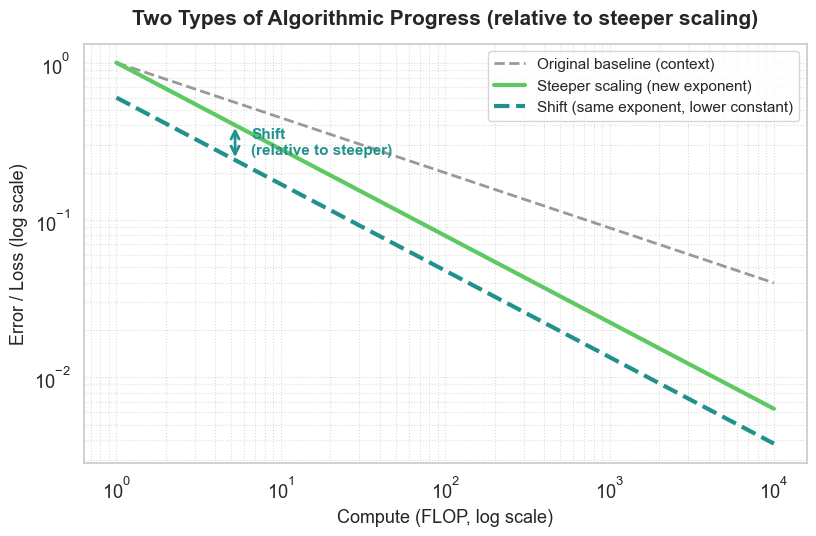

'Figures/algorithmic_progress_types.png'

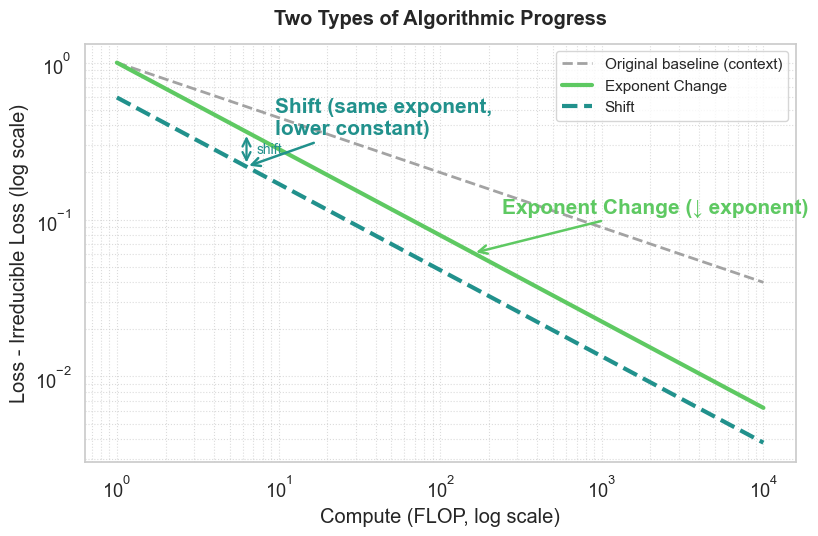

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style
sns.set(style="whitegrid", palette="viridis", font_scale=1.2)

# ---------------- USER-EDITABLE PARAMETERS ----------------
# Context/original baseline
A0, alpha0 = 1.0, 0.35

# Steeper scaling (new exponent) — SOLID reference
A1, alpha1 = 1.0, 0.55

# Shift relative to the steeper scaling (same exponent, lower constant)
shift_factor = 0.6
# ---------------------------------------------------------

def power_law(C, A, alpha):
    return A * C**(-alpha)

# Domain
C = np.logspace(0, 4, 400)

# Curves
ctx = power_law(C, A0, alpha0)                     # gray dashed (context)
steeper = power_law(C, A1, alpha1)                 # solid (reference)
shifted = power_law(C, A1 * shift_factor, alpha1)  # dashed (same slope)

# Colors
pal = sns.color_palette("viridis", 3)
col_ctx = "0.6"
col_steeper = pal[2]
col_shift = pal[1]

# Plot
fig, ax = plt.subplots(figsize=(8.6, 5.6))

ax.loglog(C, ctx, "--", lw=2, color=col_ctx, alpha=0.9, label="Original baseline (context)")
ax.loglog(C, steeper, "-", lw=3, color=col_steeper, label="Exponent Change")
ax.loglog(C, shifted, "--", lw=3, color=col_shift, label="Shift")

# Title / labels
ax.set_title("Two Types of Algorithmic Progress", weight="bold", pad=14)
ax.set_xlabel("Compute (FLOP, log scale)")
ax.set_ylabel("Loss - Irreducible Loss (log scale)")

ax.grid(which="both", linestyle=":", linewidth=0.8, alpha=0.7)

# ---------- Clear, unambiguous arrow labels ----------
# Arrow to STEEPER line with text "Exponent Change"
x_s = C[int(len(C)*0.55)]
y_s = power_law(x_s, A1, alpha1)
ax.annotate("Exponent Change (↓ exponent)",
            xy=(x_s, y_s),
            xytext=(x_s*1.5, y_s*1.8),
            fontsize=15, color=col_steeper, weight="bold",
            arrowprops=dict(arrowstyle="->", lw=1.8, color=col_steeper))

# Arrow to SHIFTED line with text "Shift"
x_sh = C[int(len(C)*0.20)]
y_sh = power_law(x_sh, A1 * shift_factor, alpha1)
ax.annotate("Shift (same exponent,\nlower constant)",
            xy=(x_sh, y_sh),
            xytext=(x_sh*1.5, y_sh*1.6),
            fontsize=15, color=col_shift, weight="bold",
            arrowprops=dict(arrowstyle="->", lw=1.8, color=col_shift))

# Also show a small vertical bracket to visualize shift magnitude at one x
ax.annotate("", xy=(x_sh, y_sh), xytext=(x_sh, power_law(x_sh, A1, alpha1)),
            arrowprops=dict(arrowstyle="<->", lw=1.6, color=col_shift, shrinkA=3, shrinkB=3))
ax.text(x_sh*1.15, np.sqrt(y_sh*power_law(x_sh, A1, alpha1)), "shift", va="center",
        fontsize=10, color=col_shift)

ax.legend(loc="upper right", frameon=True, fontsize=11)

plt.tight_layout()

out_path = "Figures/algorithmic_progress_types.png"
plt.savefig(out_path, dpi=250, bbox_inches="tight")
out_path
